In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
import joblib

# ------------------------------
# Step 1: Load Data and Preprocess
# ------------------------------
data = pd.read_csv("Foosball.csv")

# Create binary target: 1 if team1 wins, 0 otherwise.
data['winner'] = (data['team1Goals'] > data['team2Goals']).astype(int)

# Convert gameDate to datetime and compute days_since from a fixed min_date.
data['gameDate'] = pd.to_datetime(data['gameDate'])
min_date = pd.Timestamp("2024-10-04 00:00:00")
data['days_since'] = (data['gameDate'] - min_date).dt.days

# ------------------------------
# Step 2: Data Augmentation - Swap Teams
# ------------------------------
def augment_row(row):
    """
    Given a row, return a list of two rows:
    - the original row,
    - a swapped version where team1 and team2 players are swapped and the target is inverted.
    """
    row_orig = row.copy()
    row_swap = row.copy()
    # Swap team player columns
    row_swap['player1Name'] = row['player3Name']
    row_swap['player2Name'] = row['player4Name']
    row_swap['player3Name'] = row['player1Name']
    row_swap['player4Name'] = row['player2Name']
    # Invert the target outcome
    row_swap['winner'] = 1 - row['winner']
    return [row_orig, row_swap]

augmented_rows = []
for _, row in data.iterrows():
    augmented_rows.extend(augment_row(row))
data_aug = pd.DataFrame(augmented_rows)

# Define features and target for training.
features = ['player1Name', 'player2Name', 'player3Name', 'player4Name', 'days_since']
target = 'winner'

# ------------------------------
# Step 3: Define a Symmetric Player Feature Transformer
# ------------------------------
# Pre-defined list of player names (the categories for one-hot encoding)
players_list = ['Bob', 'Lucas', 'Robin', 'Salma', 'Keon', 'Ruby', 'Jeffrey',
                'Luuk', 'Hans', 'Lars', 'Cathleen', 'Roel', 'Ilhan', 'Sander', 'Jakko',
                'Berkan', 'Amir', 'Ellen', 'Arian', 'Lara', 'Aart-Jan', 'Mohammad',
                'Andres', 'Norent', 'Isabella', 'Jeroen']

def aggregate_team_features(X):
    """
    X: numpy array of shape (n_samples, 4 * n_players) produced by one-hot encoding
       the four player columns (in order: player1, player2, player3, player4).
    This function aggregates the one-hot features for each team:
      - team1_agg: sum of player1 and player2 one-hot vectors.
      - team2_agg: sum of player3 and player4 one-hot vectors.
    Then it returns the difference (team1_agg - team2_agg) so that the resulting
    feature is invariant to the order of players within each team.
    """
    n_players = len(players_list)
    team1 = X[:, :n_players] + X[:, n_players:2*n_players]
    team2 = X[:, 2*n_players:3*n_players] + X[:, 3*n_players:4*n_players]
    return team1 - team2

# Create a pipeline for processing the player name columns:
players_pipeline = Pipeline([
    # One-hot encode each of the four player columns. We specify the same categories for each.
    ('onehot', OneHotEncoder(categories=[players_list] * 4, sparse_output=False, handle_unknown='ignore')),
    # Aggregate the one-hot vectors into a single symmetric feature vector (difference between teams).
    ('aggregate', FunctionTransformer(aggregate_team_features))
])

# ------------------------------
# Step 4: Build the Overall Preprocessing and Modeling Pipeline
# ------------------------------
# Combine the players_pipeline with the days_since feature.
preprocessor = ColumnTransformer(
    transformers=[
        ('players', players_pipeline, ['player1Name', 'player2Name', 'player3Name', 'player4Name']),
        ('days', 'passthrough', ['days_since'])
    ]
)

# Build the full pipeline with the preprocessor and a classifier.
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# ------------------------------
# Step 5: Train and Save the Model
# ------------------------------
X_train = data_aug[features]
y_train = data_aug[target]

model_pipeline.fit(X_train, y_train)

# Save the model for future use.
joblib.dump(model_pipeline, "foosball_model_LR_aug.pkl")


c:\Users\AmirAtashinBIM-Conne\.conda\envs\ams\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['foosball_model_LR_aug.pkl']

Model Accuracy: 0.6522
              precision    recall  f1-score   support

           1       0.68      0.64      0.66       192
           2       0.63      0.67      0.65       176

    accuracy                           0.65       368
   macro avg       0.65      0.65      0.65       368
weighted avg       0.65      0.65      0.65       368



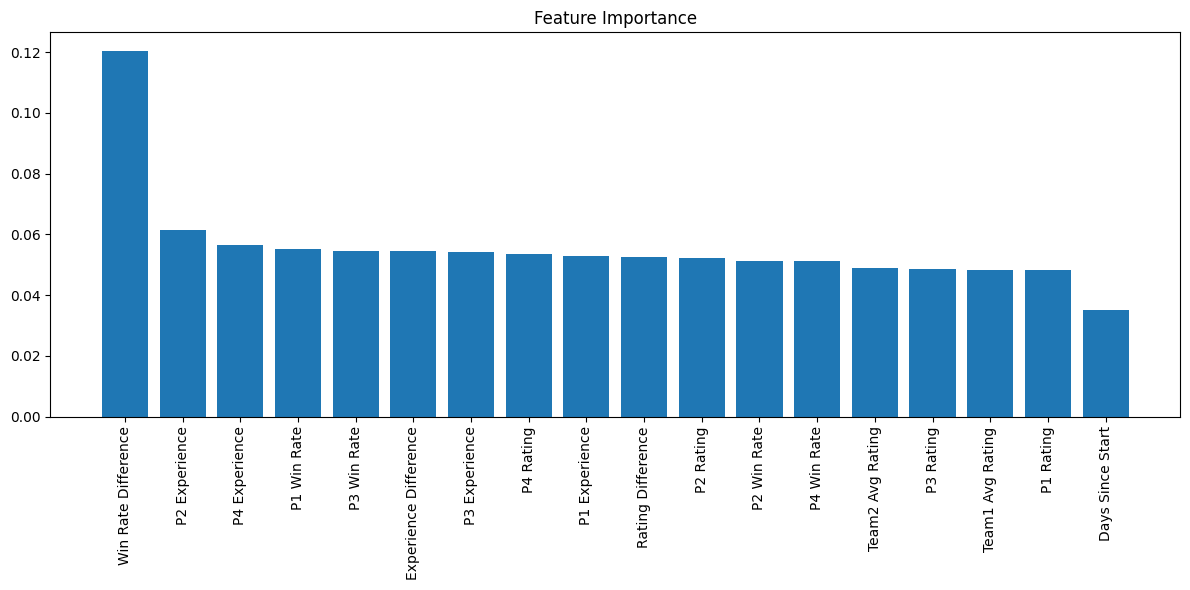


Match: Salma & Norent vs Amir & Isabella
Predicted winner: Team 1
Team 1 win probability: 0.45
Team 2 win probability: 0.55

Model saved as 'foosball_model.pkl'


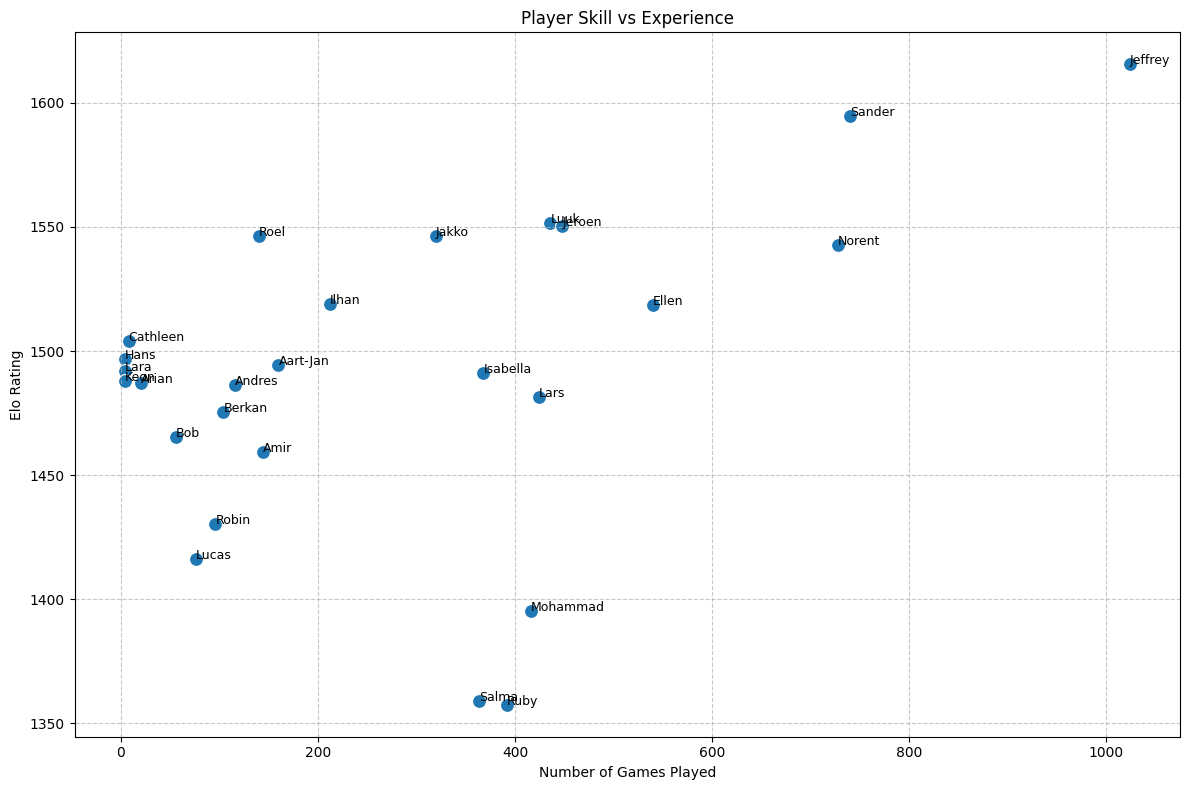

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load the data
df = pd.read_csv("Foosball.csv")

# Add winner column with a lambda function
df['winner'] = df.apply(lambda row: 1 if row['team1Goals'] > row['team2Goals'] else 2, axis=1)

# Convert game date to datetime and calculate days since first match
df['gameDate'] = pd.to_datetime(df['gameDate'])
df['days_since_start'] = (df['gameDate'] - df['gameDate'].min()).dt.days

# Define all player names
all_players = ['Aart-Jan', 'Amir', 'Andres', 'Arian', 'Berkan', 'Bob', 'Cathleen', 
               'Ellen', 'Hans', 'Ilhan', 'Isabella', 'Jakko', 'Jeffrey', 'Jeroen', 
               'Keon', 'Lara', 'Lars', 'Lucas', 'Luuk', 'Mohammad', 'Norent', 
               'Robin', 'Roel', 'Ruby', 'Salma', 'Sander']

# Initialize player stats dictionaries
player_ratings = {player: 1500 for player in all_players}
player_experience = {player: 0 for player in all_players}
player_win_rates = {player: [] for player in all_players}

# Sort data by date
df = df.sort_values('gameDate')

def standardize_team(player1, player2):
    return (player1, player2) if player1 < player2 else (player2, player1)

def create_features(matches, historical=True):
    features = []
    targets = []
    
    if historical:
        temp_ratings = player_ratings.copy()
        temp_experience = player_experience.copy()
        player_wins = {player: 0 for player in all_players}
        player_games = {player: 0 for player in all_players}
    
    for idx, match in matches.iterrows():
        p1, p2 = standardize_team(match['player1Name'], match['player2Name'])
        p3, p4 = standardize_team(match['player3Name'], match['player4Name'])
        
        if historical:
            p1_rating, p2_rating = temp_ratings[p1], temp_ratings[p2]
            p3_rating, p4_rating = temp_ratings[p3], temp_ratings[p4]
            
            p1_exp, p2_exp = temp_experience[p1], temp_experience[p2]
            p3_exp, p4_exp = temp_experience[p3], temp_experience[p4]
            
            p1_win_rate = player_wins[p1] / max(1, player_games[p1]) if player_games[p1] > 0 else 0.5
            p2_win_rate = player_wins[p2] / max(1, player_games[p2]) if player_games[p2] > 0 else 0.5
            p3_win_rate = player_wins[p3] / max(1, player_games[p3]) if player_games[p3] > 0 else 0.5
            p4_win_rate = player_wins[p4] / max(1, player_games[p4]) if player_games[p4] > 0 else 0.5
        else:
            p1_rating, p2_rating = player_ratings[p1], player_ratings[p2]
            p3_rating, p4_rating = player_ratings[p3], player_ratings[p4]
            
            p1_exp, p2_exp = player_experience[p1], player_experience[p2]
            p3_exp, p4_exp = player_experience[p3], player_experience[p4]
            
            p1_win_rate = np.mean(player_win_rates[p1]) if player_win_rates[p1] else 0.5
            p2_win_rate = np.mean(player_win_rates[p2]) if player_win_rates[p2] else 0.5
            p3_win_rate = np.mean(player_win_rates[p3]) if player_win_rates[p3] else 0.5
            p4_win_rate = np.mean(player_win_rates[p4]) if player_win_rates[p4] else 0.5
        
        team1_avg_rating = (p1_rating + p2_rating) / 2
        team2_avg_rating = (p3_rating + p4_rating) / 2
        team1_avg_exp = (p1_exp + p2_exp) / 2
        team2_avg_exp = (p3_exp + p4_exp) / 2
        team1_win_rate = (p1_win_rate + p2_win_rate) / 2
        team2_win_rate = (p3_win_rate + p4_win_rate) / 2
        
        rating_diff = team1_avg_rating - team2_avg_rating
        exp_diff = team1_avg_exp - team2_avg_exp
        win_rate_diff = team1_win_rate - team2_win_rate
        
        days_since_start = match['days_since_start'] if historical else (datetime.now() - df['gameDate'].min()).days
        
        feature = [
            p1_rating, p2_rating, p3_rating, p4_rating,
            p1_exp, p2_exp, p3_exp, p4_exp,
            p1_win_rate, p2_win_rate, p3_win_rate, p4_win_rate,
            team1_avg_rating, team2_avg_rating,
            rating_diff, exp_diff, win_rate_diff,
            days_since_start
        ]
        
        features.append(feature)
        if historical:
            targets.append(match['winner'])
            
            # Update player stats after the match
            winner = match['winner']
            
            temp_experience[p1] += 1
            temp_experience[p2] += 1
            temp_experience[p3] += 1
            temp_experience[p4] += 1
            
            player_games[p1] += 1
            player_games[p2] += 1
            player_games[p3] += 1
            player_games[p4] += 1
            
            if winner == 1:
                player_wins[p1] += 1
                player_wins[p2] += 1
            else:
                player_wins[p3] += 1
                player_wins[p4] += 1
            
            # Update ratings (Elo system)
            K = 32
            team1_expected = 1 / (1 + 10**((team2_avg_rating - team1_avg_rating) / 400))
            team2_expected = 1 - team1_expected
            
            team1_actual = 1 if winner == 1 else 0
            team2_actual = 1 - team1_actual
            
            team1_rating_change = K * (team1_actual - team1_expected)
            team2_rating_change = K * (team2_actual - team2_expected)
            
            exp_factor1 = 1 / (1 + 0.1 * team1_avg_exp)
            exp_factor2 = 1 / (1 + 0.1 * team2_avg_exp)
            
            team1_adj_change = team1_rating_change * exp_factor1
            team2_adj_change = team2_rating_change * exp_factor2
            
            temp_ratings[p1] += team1_adj_change
            temp_ratings[p2] += team1_adj_change
            temp_ratings[p3] += team2_adj_change
            temp_ratings[p4] += team2_adj_change
    
    if historical:
        player_ratings.update(temp_ratings)
        player_experience.update(temp_experience)
        
        for player in all_players:
            win_rate = player_wins[player] / max(1, player_games[player]) if player_games[player] > 0 else 0.5
            player_win_rates[player].append(win_rate)
    
    return np.array(features), np.array(targets) if historical else None

def augment_data(df):
    augmented_data = []
    
    for _, row in df.iterrows():
        # Original match
        augmented_data.append(row.copy())
        
        # Swap players within Team 1
        swapped_team1 = row.copy()
        swapped_team1['player1Name'], swapped_team1['player2Name'] = row['player2Name'], row['player1Name']
        augmented_data.append(swapped_team1)
        
        # Swap players within Team 2
        swapped_team2 = row.copy()
        swapped_team2['player3Name'], swapped_team2['player4Name'] = row['player4Name'], row['player3Name']
        augmented_data.append(swapped_team2)
        
        # Swap both teams
        swapped_teams = row.copy()
        swapped_teams['player1Name'], swapped_teams['player3Name'] = row['player3Name'], row['player1Name']
        swapped_teams['player2Name'], swapped_teams['player4Name'] = row['player4Name'], row['player2Name']
        swapped_teams['team1Goals'], swapped_teams['team2Goals'] = row['team2Goals'], row['team1Goals']
        swapped_teams['winner'] = 3 - row['winner']  # Flip 1 to 2 and 2 to 1
        augmented_data.append(swapped_teams)
    
    return pd.DataFrame(augmented_data)

# Augment data and create features
augmented_df = augment_data(df)
X, y = create_features(augmented_df, historical=True)

# Split data 
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Create pipeline
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Evaluate
y_pred = model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

# Feature importance
feature_names = [
    'P1 Rating', 'P2 Rating', 'P3 Rating', 'P4 Rating',
    'P1 Experience', 'P2 Experience', 'P3 Experience', 'P4 Experience',
    'P1 Win Rate', 'P2 Win Rate', 'P3 Win Rate', 'P4 Win Rate',
    'Team1 Avg Rating', 'Team2 Avg Rating',
    'Rating Difference', 'Experience Difference', 'Win Rate Difference',
    'Days Since Start'
]

importances = model_pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

def predict_winner(player1, player2, player3, player4):
    p1, p2 = standardize_team(player1, player2)
    p3, p4 = standardize_team(player3, player4)
    
    new_match = pd.DataFrame({
        'player1Name': [p1],
        'player2Name': [p2],
        'player3Name': [p3],
        'player4Name': [p4],
        'days_since_start': [(datetime.now() - df['gameDate'].min()).days]
    })
    
    X_new, _ = create_features(new_match, historical=False)
    
    prediction = model_pipeline.predict(X_new)[0]
    probabilities = model_pipeline.predict_proba(X_new)[0]
    
    return {
        'predicted_winner': 'Team 1' if prediction == 1 else 'Team 2',
        'team1_probability': probabilities[0] if prediction == 2 else probabilities[1],
        'team2_probability': probabilities[1] if prediction == 2 else probabilities[0]
    }

# Example prediction
example_prediction = predict_winner('Salma', 'Norent', 'Amir', 'Isabella')
print(f"\nMatch: Salma & Norent vs Amir & Isabella")
print(f"Predicted winner: {example_prediction['predicted_winner']}")
print(f"Team 1 win probability: {example_prediction['team1_probability']:.2f}")
print(f"Team 2 win probability: {example_prediction['team2_probability']:.2f}")

# Save the model
joblib.dump(model_pipeline, "foosball_model.pkl")
print("\nModel saved as 'foosball_model.pkl'")

# Generate player skill rankings
player_skill_df = pd.DataFrame({
    'Player': list(player_ratings.keys()),
    'Rating': list(player_ratings.values()),
    'Experience': list(player_experience.values())
}).sort_values('Rating', ascending=False)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=player_skill_df, x='Experience', y='Rating', s=100)

for i, row in player_skill_df.iterrows():
    plt.text(row['Experience'], row['Rating'], row['Player'], fontsize=9)
    
plt.title('Player Skill vs Experience')
plt.xlabel('Number of Games Played')
plt.ylabel('Elo Rating')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [15]:
example_prediction = predict_winner('Amir', 'Andres', 'Jeffrey', 'Salma')
print("\nExample Prediction:")
print(f"Predicted winner: {example_prediction['predicted_winner']}")
print(f"Team 1 win probability: {example_prediction['team1_probability']:.2f}")
print(f"Team 2 win probability: {example_prediction['team2_probability']:.2f}")


Example Prediction:
Predicted winner: Team 2
Team 1 win probability: 0.31
Team 2 win probability: 0.69


In [23]:
all_players_name = set(data["player1Name"].unique().tolist() + data["player2Name"].unique().tolist() + data["player3Name"].unique().tolist() + data["player4Name"].unique().tolist())
print(list(all_players_name))

['Bob', 'Lucas', 'Robin', 'Salma', 'Keon', 'Ruby', 'Jeffrey', 'Luuk', 'Hans', 'Lars', 'Cathleen', 'Roel', 'Ilhan', 'Sander', 'Jakko', 'Berkan', 'Amir', 'Ellen', 'Arian', 'Lara', 'Aart-Jan', 'Mohammad', 'Andres', 'Norent', 'Isabella', 'Jeroen']


In [8]:
df['winner'] = df.apply(lambda row: 'team1' if row['team1Goals'] > row['team2Goals'] else 'team2', axis=1)

In [3]:
players_list = ['Bob', 'Lucas', 'Robin', 'Salma', 'Keon', 'Ruby', 'Jeffrey',
                'Luuk', 'Hans', 'Lars', 'Cathleen', 'Roel', 'Ilhan', 'Sander', 'Jakko',
                'Berkan', 'Amir', 'Ellen', 'Arian', 'Lara', 'Aart-Jan', 'Mohammad',
                'Andres', 'Norent', 'Isabella', 'Jeroen']

In [4]:
players_list.sort()

In [6]:
print(players_list)

['Aart-Jan', 'Amir', 'Andres', 'Arian', 'Berkan', 'Bob', 'Cathleen', 'Ellen', 'Hans', 'Ilhan', 'Isabella', 'Jakko', 'Jeffrey', 'Jeroen', 'Keon', 'Lara', 'Lars', 'Lucas', 'Luuk', 'Mohammad', 'Norent', 'Robin', 'Roel', 'Ruby', 'Salma', 'Sander']
